<h1  align=center><font  size = 6>Predicting Solar Flares and Flare Area Classes</font></h1>

<p align="center">
    <img src="https://images.ctfassets.net/cnu0m8re1exe/1RiWk3i0ceklxImgCFDrTD/af90389b5fadb31b7142b9f98247f917/Untitled_design__54_.png?fm=jpg&fl=progressive&w=660&h=433&fit=fill" height=400  width=1000> 
</p>

<small>Picture Source:<a  href="https://images.ctfassets.net/cnu0m8re1exe/1RiWk3i0ceklxImgCFDrTD/af90389b5fadb31b7142b9f98247f917/Untitled_design__54_.png?fm=jpg&fl=progressive&w=660&h=433&fit=fill">ctfassets.net</a></small>

<br>

<h2>Statement</h2>

<p>The purpose of this study is based on the available data, it was estimated numbers of the <i>solar flares</i> production in spesific region on sun in the following 24 hours (with classes). You can run, modify and download your own model from codes. Accuracy can change due to parameters. Please let me know the best parameters.</p>

<br>

<h2>Keywords</h2>
<ul>
  <li>Multi-Output</li>
  <li>Neural Networks</li>
  <li>Space</li>
  <li>Sun</li>
  <li>Classification</li>
	<li>Deep Learning</li>
</ul>

<br>

<h2>Datasets</h2>

<p>Datasets are downloaded from <a href="https://archive.ics.uci.edu/ml/datasets/Solar+Flare">archive.ics.uci.edu</a> website. You can find the details of the datasets in that website and also in the <i>flare.names</i> named file. <i>flare.data1</i> dataset has <i>13 columns</i> and <i>323 rows without the header</i> and <i>flare.data2</i> dataset has <i>13 columns</i> and <i>1066 rows without the header</i>. The database contains 3 potential classes, one for the number of times a certain type of solar flare occured in a 24 hour period. Each instance represents captured features for 1 active region on the sun. The data are divided into two sections. <b>The second section (flare.data2) has had much more error correction applied to the it, and has consequently been treated as more reliable.</b></p>

<br>

<h2>Table of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<li><a href="https://#import">Import Libraries</a></li>
<li><a href="https://#data_preparation">Dataset Preparation</a></li>
<li><a href="https://#compile_fit">Build and Fit the Model</a></li>

<br>

<p></p>
Estimated Time Needed: <strong>15 min</strong>
</div>

<br>
<h2 align=center id="import">Import Libraries</h2>
<p>The following are the libraries we are going to use for this lab:</p>

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  get_ipython().run_line_magic('tensorflow_version', '2.x')
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

<br>
<h2 align=center id="data_preparation">Dataset Preparation (Data Preprocessing)</h2>

<p>Let's build some necessary functions for visualisation and pre-processing.</p>


In [ ]:
# Functions taken from 'Custom Models, Layers, and Loss Functions with TensorFlow' course.
# https://www.coursera.org/learn/custom-models-layers-loss-functions-with-tensorflow

def format_output(data):
    y1 = data.pop('c_class')
    y1 = np.array(y1)
    y2 = data.pop('m_class')
    y2 = np.array(y2)
    y3 = data.pop('x_class')
    y3 = np.array(y3)
    return y1, y2, y3


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def plot_metrics(metric_name, title, ylim=5):
    plt.figure(figsize = (20, 10))
    sns.set_style('whitegrid')
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.legend(['train', 'validation'])
    plt.show()

<p>Now, we can upload our data named <code>flare.data2</code>. It doesn't have named columns. We need to spesify them after importing our data into <i>dataframe</i>.</p>

In [ ]:
df = pd.read_csv('/content/flare.data2', sep=" ", skiprows=1, header=None)
df.columns = ['class', 'largest_spot_size', 'spot_dist', 'activity', 'evolution', 'flare_activity_code', 'h_complex', 'h_complex_sdisk', 'area', 'area_largest_spot', 'c_class', 'm_class', 'x_class']

In [ ]:
df.shape

(1066, 13)

<b>Attribute Information:</b>

<ol>
	<li>Code for class <i>(modified Zurich class)</i> <i>(A,B,C,D,E,F,H)</i></li>
	<li>Code for largest spot size <i>(X,R,S,A,H,K)</i></li>
	<li>Code for spot distribution <i>(X,O,I,C)</i></li>  
	<li>Activity <i>(1 = reduced, 2 = unchanged)</i></li>  
	<li>Evolution <i>(1 = decay, 2 = no growth, 3 = growth)</i></li>  
	<li>Previous 24 hour flare activity code <i>(1 = nothing as big as an M1, 2 = one M1, 3 = more activity than one M1)</i></li>  
	<li>Historically-complex <i>(1 = Yes, 2 = No)</i></li>  
	<li>Did region become historically complex on this pass across the sun's disk <i>(1 = yes, 2 = no)</i></li>  
	<li>Area <i>(1 = small, 2 = large)</i></li>  
	<li>Area of the largest spot <i>(1 = <=5, 2 = >5)</i></li>  
</ol>

<b>From all these predictors three classes of flares are predicted, which are represented in the last three columns.</b> 

11. <i>C-class flares</i> production by this region in the following 24 hours (common flares)
12. <i>M-class flares</i> production by this region in the following 24 hours (moderate flares) 
13. <i>X-class flares</i> production by this region in the following 24 hours (severe flares)

In [ ]:
print("Number of NaN values: {}.".format(df.isnull().sum().sum()))

print("Number of duplicated rows: {}.".format(df.duplicated().sum()))

Number of NaN values: 0.
Number of duplicated rows: 701.


<p>We have 701 duplicated rows. We need to drop them because we want the program to learn, not memorize.</p>

In [ ]:
dp = df[df.duplicated(keep=False)]
df.drop_duplicates(inplace= True)
print("Number of duplicated rows: {}.".format(df.duplicated().sum()))

Number of duplicated rows: 0.


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
activity,365.0,1.361644,0.481136,1.0,1.0,1.0,2.0,2.0
evolution,365.0,2.378082,0.650073,1.0,2.0,2.0,3.0,3.0
flare_activity_code,365.0,1.164384,0.519237,1.0,1.0,1.0,1.0,3.0
h_complex,365.0,1.616438,0.486921,1.0,1.0,2.0,2.0,2.0
h_complex_sdisk,365.0,1.934247,0.248191,1.0,2.0,2.0,2.0,2.0
area,365.0,1.068493,0.252937,1.0,1.0,1.0,1.0,2.0
area_largest_spot,365.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
c_class,365.0,0.775342,1.257481,0.0,0.0,0.0,1.0,8.0
m_class,365.0,0.131507,0.501886,0.0,0.0,0.0,0.0,5.0
x_class,365.0,0.016438,0.147333,0.0,0.0,0.0,0.0,2.0


<p>As we can see from the info graph, <code>area_largest_spot</code> has only one unique value. This column did not affects our prediction so we can drop it. </p>

In [ ]:
df['area_largest_spot'].unique()

array([1])

In [ ]:
df.drop(['area_largest_spot'], axis = 1, inplace = True)

In [ ]:
df.head()

,class,largest_spot_size,spot_dist,activity,evolution,flare_activity_code,h_complex,h_complex_sdisk,area,c_class,m_class,x_class
0,H,A,X,1,3,1,1,1,1,0,0,0
1,D,R,O,1,3,1,1,2,1,0,0,0
2,C,S,O,1,3,1,1,2,1,0,0,0
3,H,R,X,1,2,1,1,1,1,0,0,0
4,H,S,X,1,1,1,1,2,1,0,0,0


In [ ]:
df.tail()

,class,largest_spot_size,spot_dist,activity,evolution,flare_activity_code,h_complex,h_complex_sdisk,area,c_class,m_class,x_class
1032,D,H,O,1,2,1,2,2,1,0,0,0
1034,D,A,I,2,3,2,1,2,1,0,0,0
1046,E,A,O,1,2,1,2,2,1,4,1,0
1047,H,S,X,1,3,1,1,1,1,1,0,0
1058,H,S,X,1,2,2,2,2,1,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 1058
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   class                365 non-null    object
 1   largest_spot_size    365 non-null    object
 2   spot_dist            365 non-null    object
 3   activity             365 non-null    int64 
 4   evolution            365 non-null    int64 
 5   flare_activity_code  365 non-null    int64 
 6   h_complex            365 non-null    int64 
 7   h_complex_sdisk      365 non-null    int64 
 8   area                 365 non-null    int64 
 9   c_class              365 non-null    int64 
 10  m_class              365 non-null    int64 
 11  x_class              365 non-null    int64 
dtypes: int64(9), object(3)
memory usage: 37.1+ KB


In [ ]:
df.shape

(365, 12)

In [ ]:
df_copy = df.copy()

In [ ]:
le = LabelEncoder()
df["class"] = le.fit_transform(df['class'])
df["largest_spot_size"] = le.fit_transform(df['largest_spot_size'])
df["spot_dist"] = le.fit_transform(df['spot_dist'])

<p>Let's see the difference between label encoded columns:</p>

In [ ]:
df[['class', 'largest_spot_size', 'spot_dist']].head(10)

,class,largest_spot_size,spot_dist
0,5,0,3
1,2,3,2
2,1,4,2
3,5,3,3
4,5,4,3
5,1,0,2
6,0,5,2
7,1,0,2
8,1,0,2
12,0,5,1


In [ ]:
df_copy[['class', 'largest_spot_size', 'spot_dist']].head(10)

,class,largest_spot_size,spot_dist
0,H,A,X
1,D,R,O
2,C,S,O
3,H,R,X
4,H,S,X
5,C,A,O
6,B,X,O
7,C,A,O
8,C,A,O
12,B,X,I


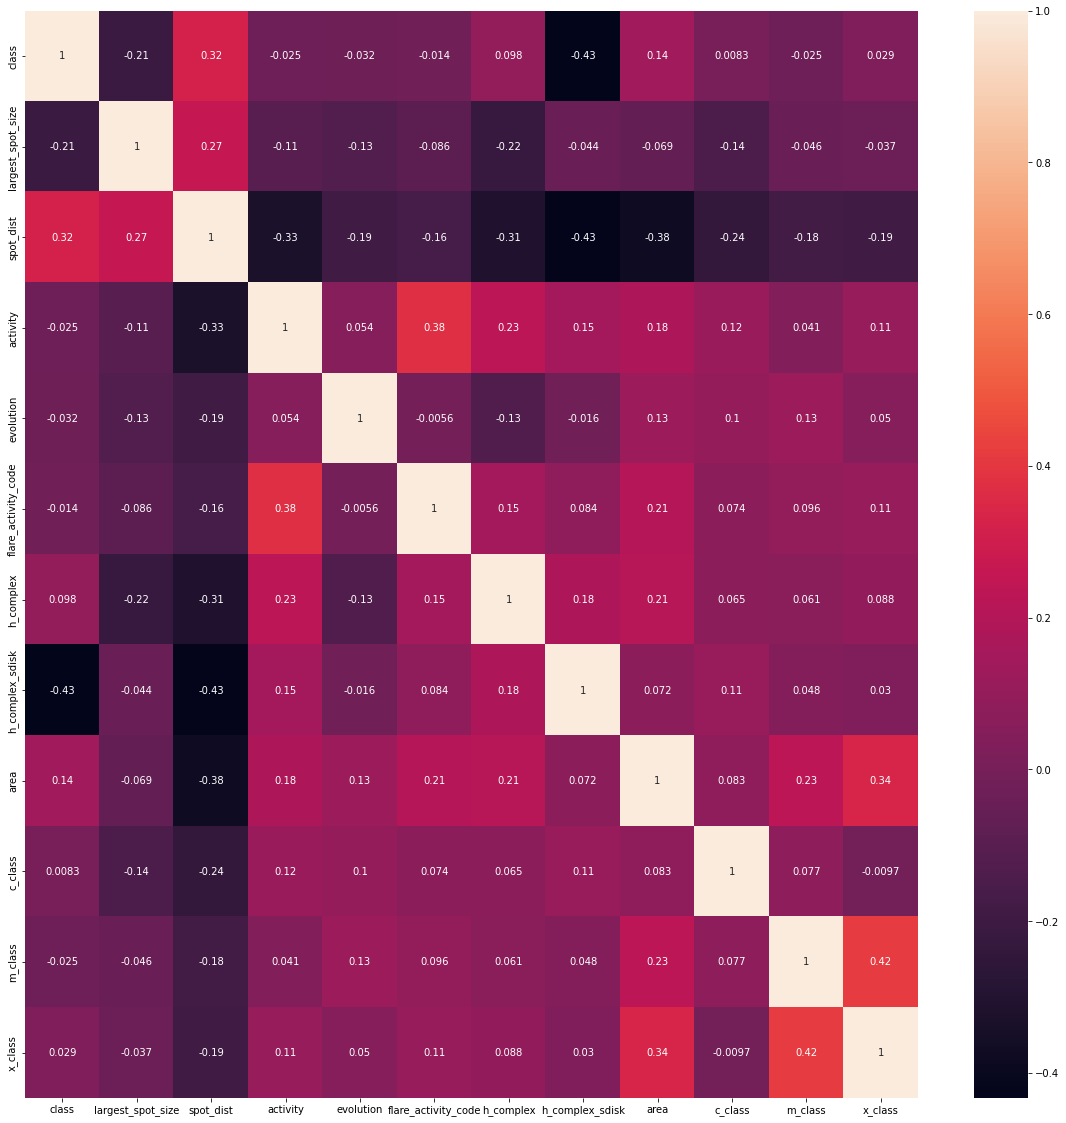

In [ ]:
plt.figure(figsize = (20, 20))
sns.heatmap(df.corr(), annot=True)

<Figure size 1440x1440 with 0 Axes>

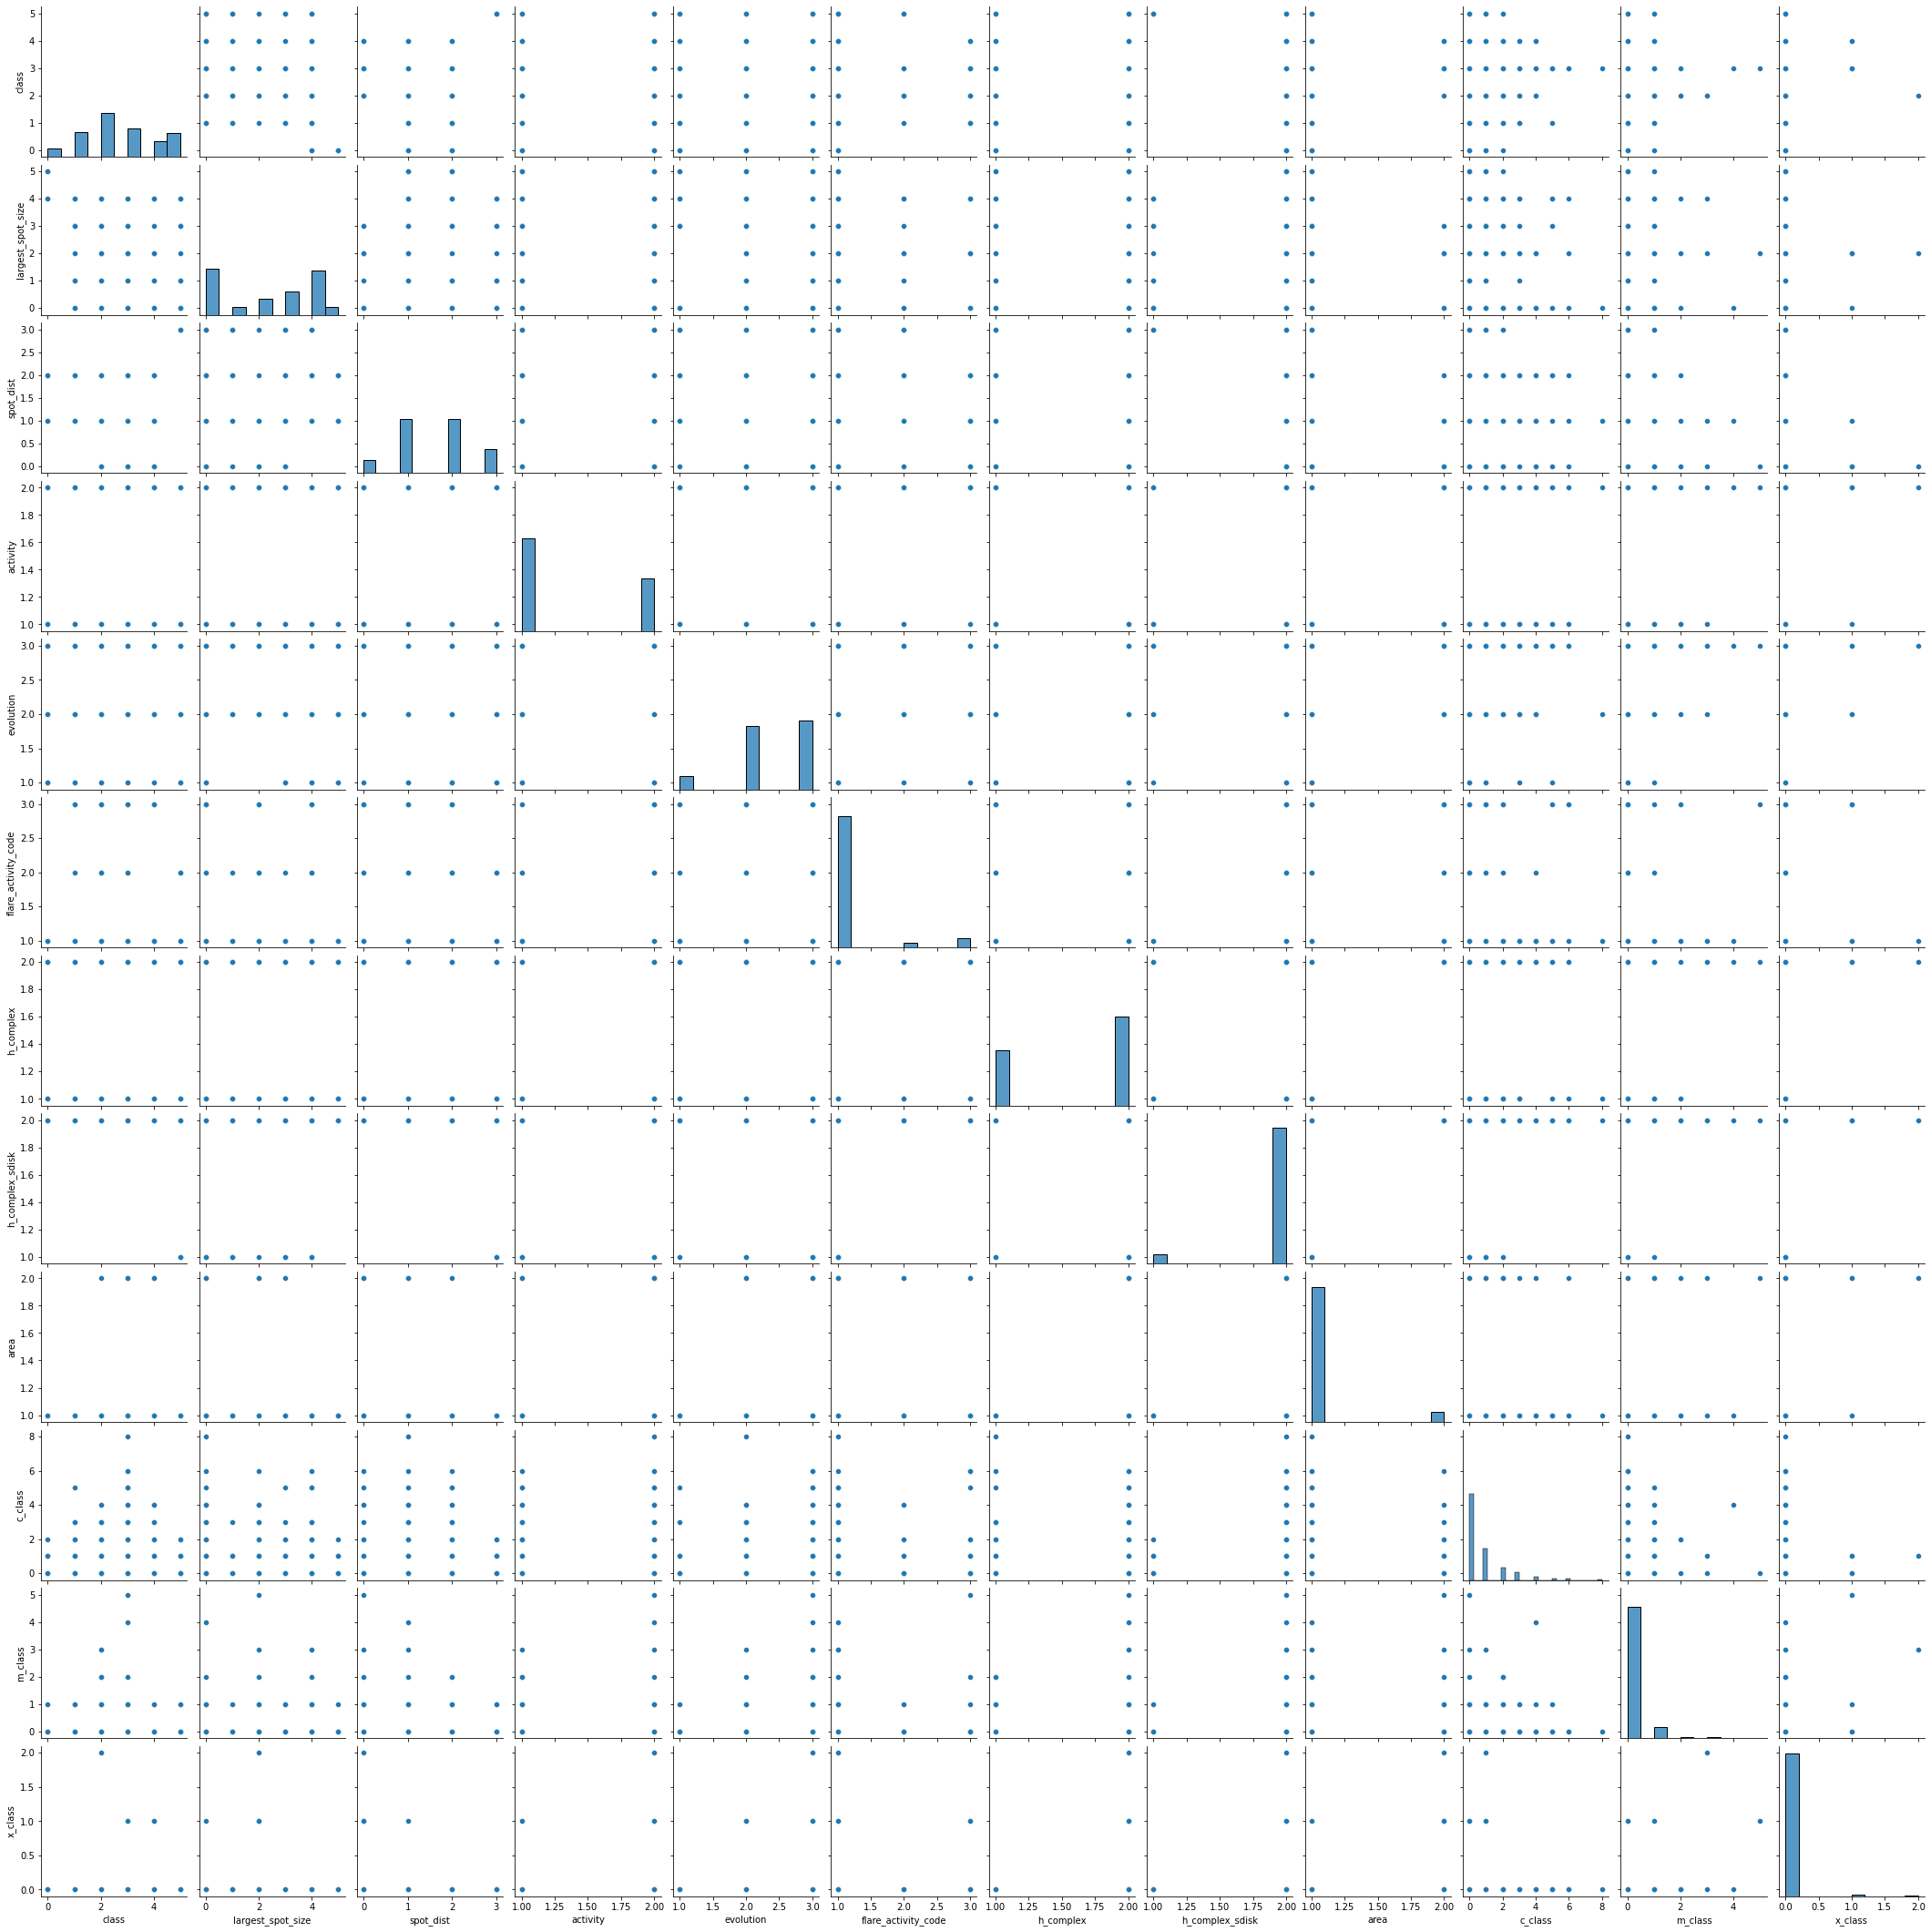

In [ ]:
plt.figure(figsize = (20, 20))
sns.pairplot(df)

<p>Split the data into train and test with 80 train / 20 test:</p>

In [ ]:
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

In [ ]:
train_stats.pop('c_class')
train_stats.pop('m_class')
train_stats.pop('x_class')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

In [ ]:
train_Y

(array([0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0,
        3, 0, 2, 0, 0, 5, 0, 0, 0, 2, 1, 6, 0, 0, 1, 2, 0, 0, 1, 3, 2, 0,
        0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 4, 0, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1,
        0, 3, 1, 0, 0, 0, 0, 1, 2, 1, 4, 2, 1, 0, 1, 0, 0, 0, 0, 1, 0, 3,
        0, 3, 0, 8, 0, 0, 3, 1, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        4, 4, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 4,
        0, 2, 2, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,
        1, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0,
        0, 1, 1, 1, 5, 0, 0, 0, 0, 1, 2, 0, 5, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 2, 0, 0, 1, 1, 0, 1, 0, 1, 4, 2, 0, 3, 0, 0, 0, 4, 0, 0, 0, 3,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 2, 1, 1, 2, 1, 0, 0, 0, 1, 2, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 3, 0, 0, 0, 2, 0, 3, 5, 0, 0, 0, 0, 0, 3,
        0, 1, 1, 4, 0, 1]),
 array([0,

In [ ]:
test_Y

(array([1, 0, 0, 2, 3, 0, 0, 1, 2, 0, 1, 1, 3, 0, 0, 1, 0, 0, 0, 1, 3, 1,
        0, 0, 0, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 0, 1,
        0, 0, 3, 0, 1, 6, 0, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 2, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]))

In [ ]:
# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

<br>
<h2 align=center id="compile_fit">Build and Fit the Model</h2>

In [ ]:
def create_model(input_len):
  input_layer = Input(shape=(len(train.columns), ))
  first_dense = Dense(units='128', activation='relu')(input_layer)
  second_dense = Dense(units='128', activation='relu')(first_dense)
  third_dense = Dense(units='64', activation='relu')(second_dense)

  fourth_dense = Dense(units='32', activation='sigmoid')(third_dense)
  y1_output = Dense(units='1', name='c_output')(fourth_dense)

  fifth_dense = Dense(units='64', activation='sigmoid')(third_dense)
  y2_output = Dense(units='1', name='m_output')(fifth_dense)

  sixth_dense = Dense(units='16', activation='sigmoid')(third_dense)
  y3_output = Dense(units='1', name='x_output')(sixth_dense)

  model = Model(inputs=input_layer, outputs=[y1_output, y2_output, y3_output])

  print(model.summary())
  return model

In [ ]:
model = create_model(train.columns)
model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          1280        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                              

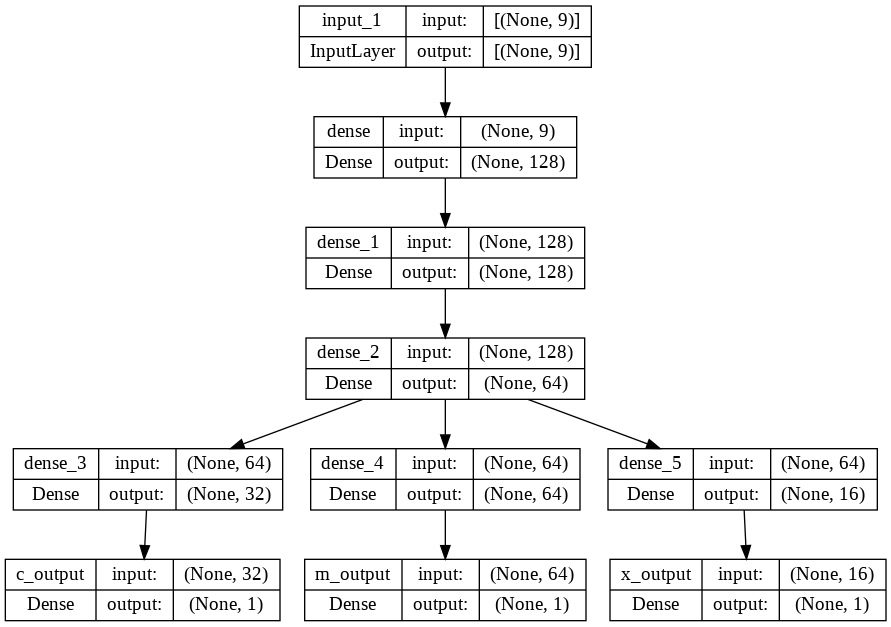

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

<p>Let's configure parameters</p>

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'c_output': 'mse', 'm_output': 'mse', 'x_output': 'mse'},
              metrics={'c_output': tf.keras.metrics.RootMeanSquaredError(),
                       'm_output': tf.keras.metrics.RootMeanSquaredError(),
                       'x_output': tf.keras.metrics.RootMeanSquaredError()})

<p>It is time to train our model!</p>

In [ ]:
EPOCHS = 500 #@param {type:"number"}
BATCH_SIZE = 10 #@param {type:"number"}

In [ ]:
history = model.fit(norm_train_X, train_Y,
                    epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(norm_test_X, test_Y))

Epoch 1/500
30/30 [==============================] - 2s 14ms/step - loss: 2.1585 - c_output_loss: 1.7912 - m_output_loss: 0.2826 - x_output_loss: 0.0846 - c_output_root_mean_squared_error: 1.3384 - m_output_root_mean_squared_error: 0.5316 - x_output_root_mean_squared_error: 0.2909 - val_loss: 1.9098 - val_c_output_loss: 1.6104 - val_m_output_loss: 0.2068 - val_x_output_loss: 0.0925 - val_c_output_root_mean_squared_error: 1.2690 - val_m_output_root_mean_squared_error: 0.4548 - val_x_output_root_mean_squared_error: 0.3041
Epoch 2/500
30/30 [==============================] - 0s 3ms/step - loss: 1.9687 - c_output_loss: 1.6556 - m_output_loss: 0.2626 - x_output_loss: 0.0504 - c_output_root_mean_squared_error: 1.2867 - m_output_root_mean_squared_error: 0.5125 - x_output_root_mean_squared_error: 0.2246 - val_loss: 1.8210 - val_c_output_loss: 1.5508 - val_m_output_loss: 0.1993 - val_x_output_loss: 0.0710 - val_c_output_root_mean_squared_error: 1.2453 - val_m_output_root_mean_squared_error: 0.4

In [ ]:
loss, C_loss, M_loss, X_loss, C_rmse, M_rmse, X_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, c_output_loss = {}, c_output_mse = {}, m_output_loss = {}, m_output_mse = {}, x_output_loss = {}, x_output_mse = {}".format(loss, C_loss, C_rmse, M_loss, M_rmse, X_loss, X_rmse))

3/3 [==============================] - 0s 4ms/step - loss: 1.7712 - c_output_loss: 1.5296 - m_output_loss: 0.1901 - x_output_loss: 0.0515 - c_output_root_mean_squared_error: 1.2368 - m_output_root_mean_squared_error: 0.4360 - x_output_root_mean_squared_error: 0.2270
Loss = 1.7712135314941406, c_output_loss = 1.5295665264129639, c_output_mse = 1.236756443977356, m_output_loss = 0.1901276856660843, m_output_mse = 0.4360363483428955, x_output_loss = 0.051519110798835754, x_output_mse = 0.22697821259498596


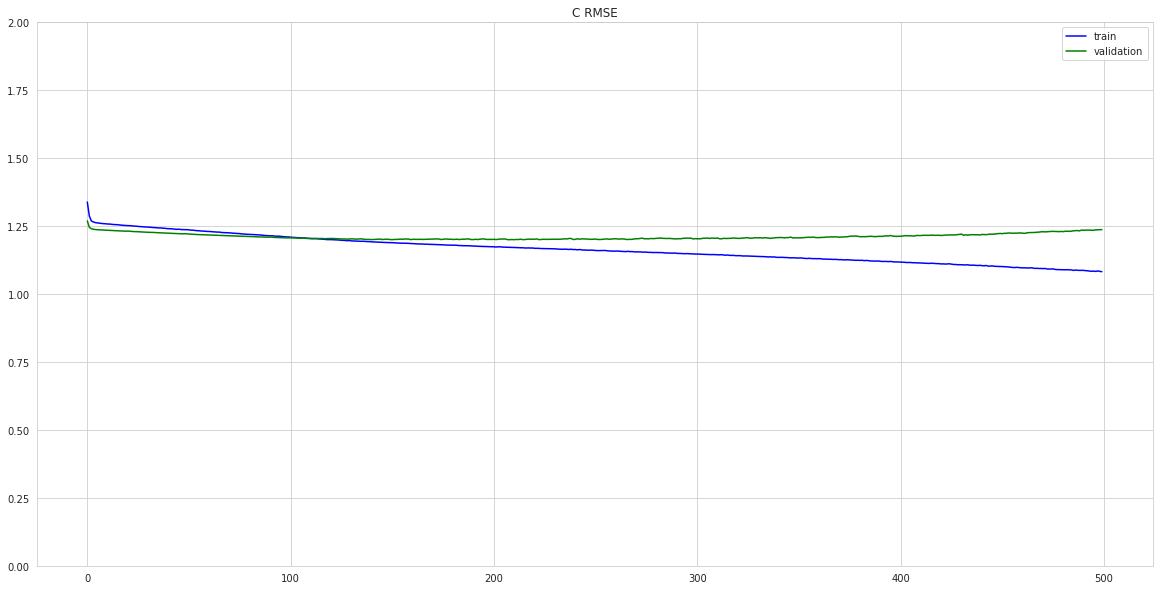

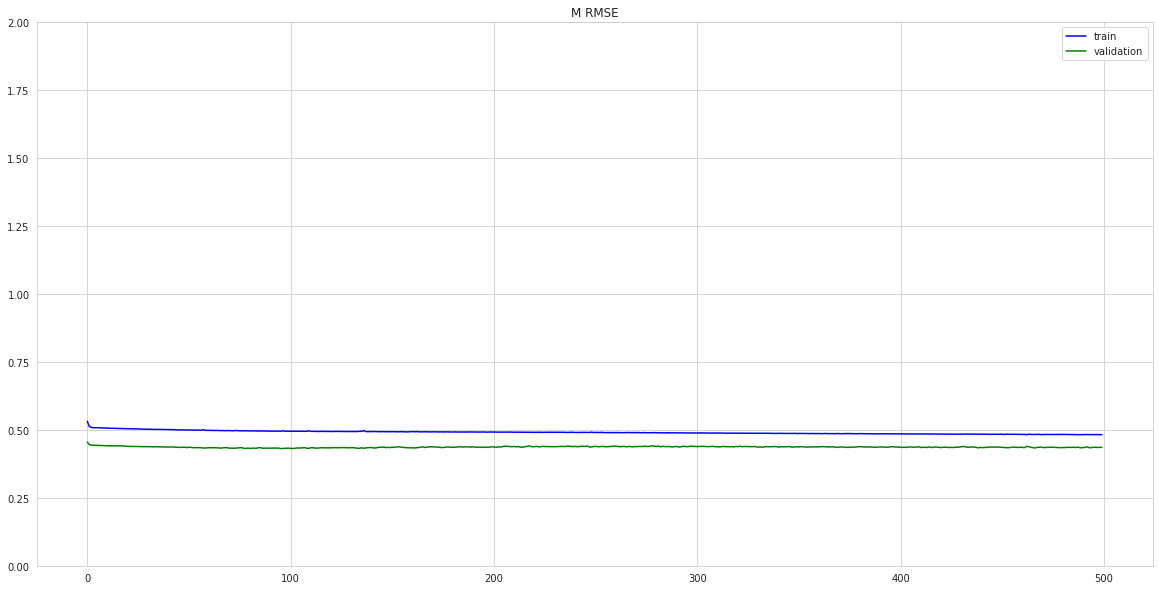

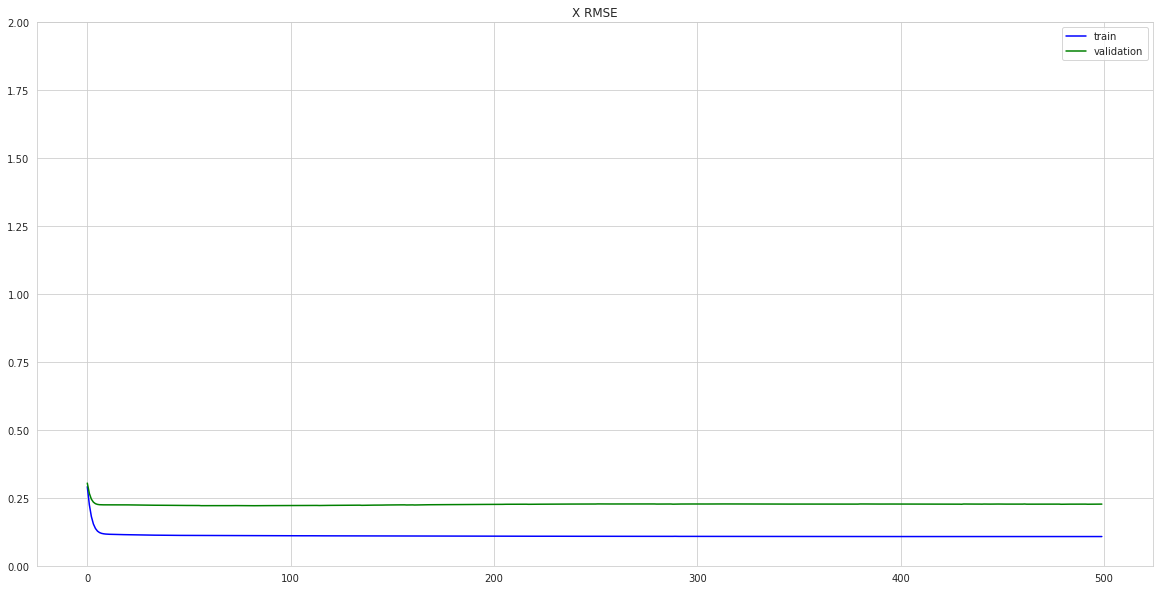

In [ ]:
plot_metrics(metric_name='c_output_root_mean_squared_error', title='C RMSE', ylim=2)
plot_metrics(metric_name='m_output_root_mean_squared_error', title='M RMSE', ylim=2)
plot_metrics(metric_name='x_output_root_mean_squared_error', title='X RMSE', ylim=2)

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
model.save('my_model.h5')

<h1>Contact Me</h1>
<p>If you have something to say to me please contact me:</p>

<ul>
  <li>Twitter: <a href="https://twitter.com/Doguilmak">Doguilmak</a></li>
  <li>Mail address: doguilmak@gmail.com</li>
</ul>


In [38]:
from datetime import datetime
print(f"Changes have been made to the project on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Changes have been made to the project on 2022-12-27 22:48:23
